In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gmean

from modelforge.visualization.consolidation_helper import read_experiment_results_consolidation

sns.set_style("white")

from modelforge.visualization.helper import dataset_sizes, datasets, losses, read_experiment_results



In [2]:
experiment_date = "2025-03-25-15:28"
experiment = "method_ranking"

In [3]:
df, pipeline_groups, pipeline_groups_clean = read_experiment_results(experiment, experiment_date)

In [4]:
df['pipeline_group'].unique()

array(['prediction', 'prediction_loss', 'cross_performance', 'shap',
       'composing', 'random'], dtype=object)

In [5]:
pipeline_groups_clean = sorted(pipeline_groups_clean)
pipeline_groups = sorted(pipeline_groups)
pipeline_groups = [i for i in pipeline_groups if "random" not in i]
pipeline_groups_clean = [i for i in pipeline_groups_clean if "random" not in i]

In [6]:
df = df[df['pipeline'] != 'random_clustering']

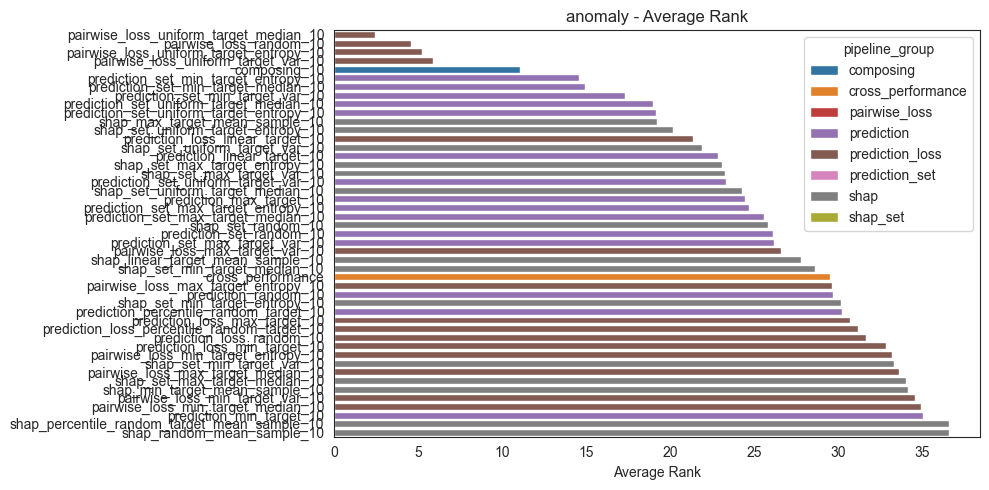

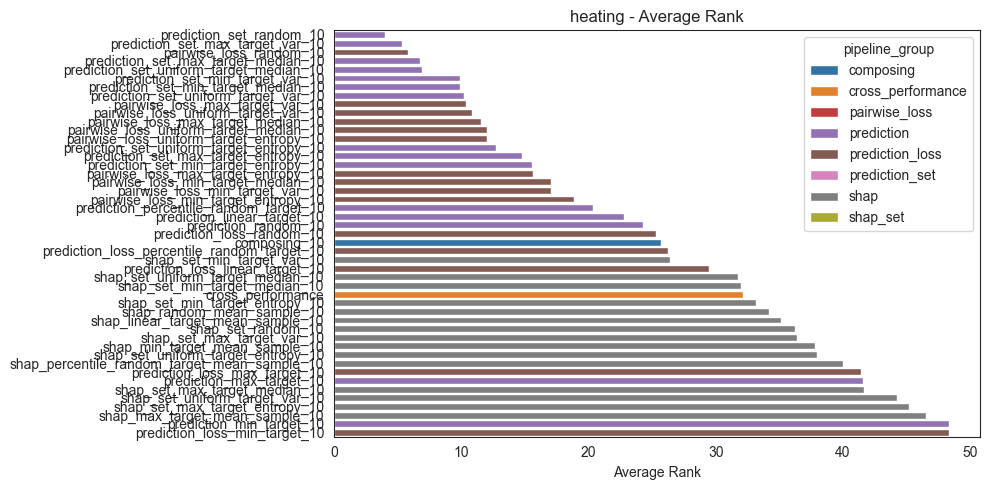

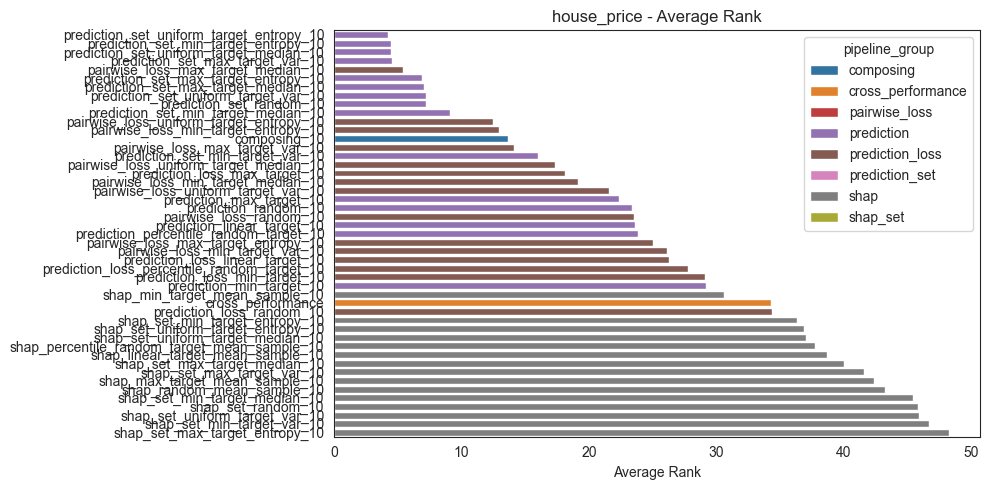

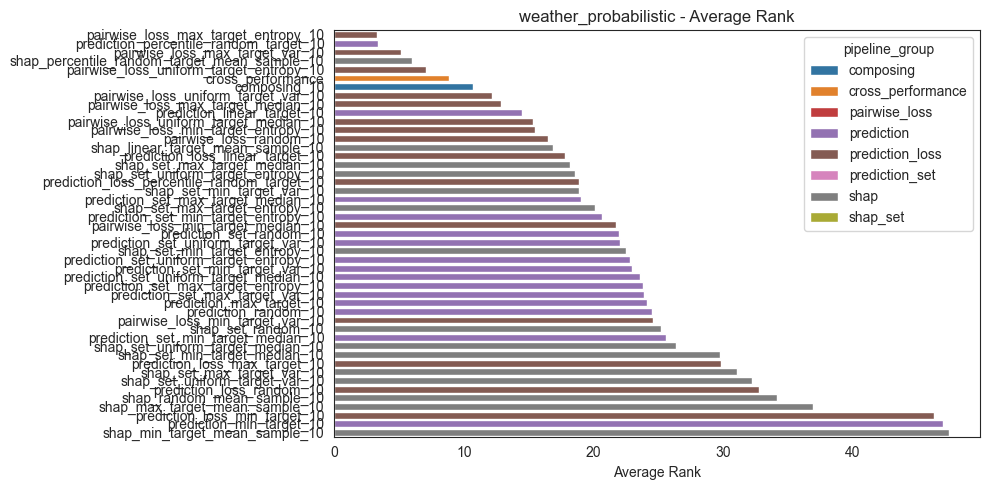

In [7]:
from modelforge.visualization.helper import losses_maximize

overall_ranks = {k: [] for k in df["pipeline"].unique()}

for dataset, dataset_size, loss_maximize in zip(datasets, dataset_sizes, losses_maximize):
    df_dataset = df[df["dataset"] == dataset].copy()
    df_dataset["share_retained"] = df_dataset["num_clusters"].apply(lambda x: int(x) / dataset_size)
    df_dataset = df_dataset.sort_values(by="share_retained")
    ranks = {k: [] for k in df_dataset["pipeline"].unique()}
    for share in df_dataset["share_retained"].unique():
        df_share = df_dataset[df_dataset["share_retained"] == share]
        df_share = df_share.sort_values(by="cluster_loss", ascending=not loss_maximize).reset_index(drop=True)
        for rank, pipeline in enumerate(df_share["pipeline"]):
            ranks[pipeline].append(rank + 1)
    average_rank = {k: np.mean(v) for k, v in ranks.items()}
    for pipeline, rank in average_rank.items():
        overall_ranks[pipeline].append(rank)
    average_rank_df = pd.DataFrame(average_rank.items(), columns=["pipeline", "average_rank"])
    # order by average rank
    average_rank_df = average_rank_df.sort_values(by="average_rank")
    average_rank_df = average_rank_df.merge(df_dataset[["pipeline", "pipeline_group"]].drop_duplicates(), on="pipeline")
    plt.figure(figsize=(10, 5))
    sns.barplot(data=average_rank_df, x="average_rank", y="pipeline", hue="pipeline_group",
                hue_order=pipeline_groups_clean)
    plt.title(f"{dataset} - Average Rank")
    plt.xlabel("Average Rank")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(f"../../reports/figures/method_ranking/{dataset}_average_rank.png", dpi=300)
    plt.show()
    plt.close()




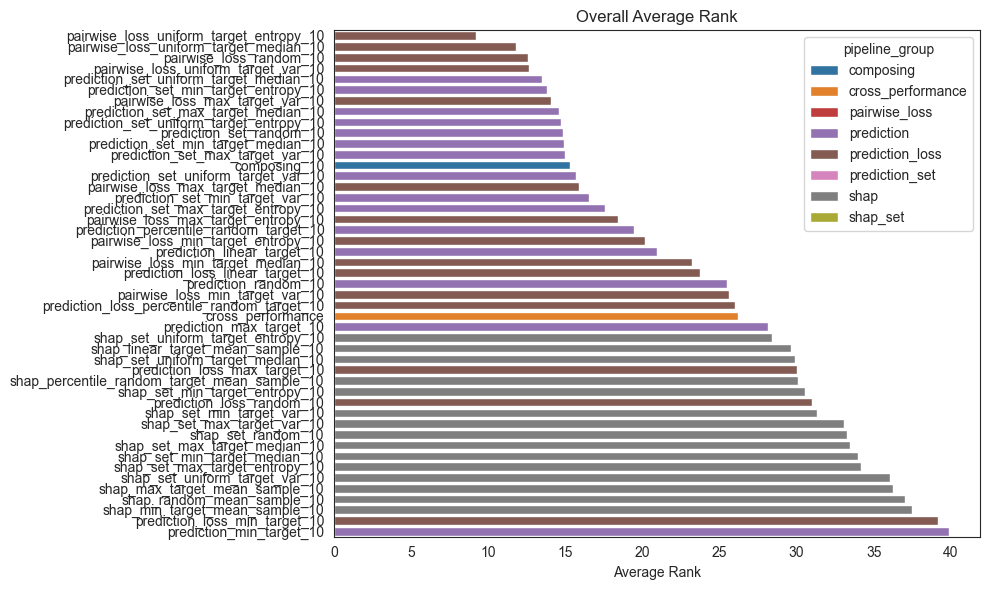

In [8]:
overall_average_rank = {k: np.mean(v) for k, v in overall_ranks.items()}
overall_rank_df = pd.DataFrame(overall_average_rank.items(), columns=["pipeline", "average_rank"])
overall_rank_df = overall_rank_df.sort_values(by="average_rank")
overall_rank_df = overall_rank_df.merge(df[["pipeline", "pipeline_group"]].drop_duplicates(), on="pipeline")
plt.figure(figsize=(10, 6))
sns.barplot(data=overall_rank_df, x="average_rank", y="pipeline", hue="pipeline_group", hue_order=pipeline_groups_clean)
plt.title("Overall Average Rank")
plt.xlabel("Average Rank")
plt.ylabel("")
plt.tight_layout()
plt.savefig("../../reports/figures/method_ranking/overall_average_rank.png", dpi=300)
plt.show()
plt.close()

In [9]:
df[df["pipeline"] == "prediction_set_uniform_target_median_10"]

,dataset,loss,pipeline,pipeline_group,cluster_loss,model_loss,cluster_var,model_var,num_clusters
500,anomaly,roc_auc,prediction_set_uniform_target_median_10,prediction,0.575566,0.605849,0.014874,0.029264,135
501,anomaly,roc_auc,prediction_set_uniform_target_median_10,prediction,0.577045,0.605849,0.013094,0.029264,132
502,anomaly,roc_auc,prediction_set_uniform_target_median_10,prediction,0.566527,0.605849,0.009964,0.029264,92
503,anomaly,roc_auc,prediction_set_uniform_target_median_10,prediction,0.569735,0.605849,0.011133,0.029264,103
504,anomaly,roc_auc,prediction_set_uniform_target_median_10,prediction,0.543556,0.605849,0.004247,0.029264,57
...,...,...,...,...,...,...,...,...,...
7976,weather_probabilistic,crps,prediction_set_uniform_target_median_10,prediction,0.831077,0.854452,0.001268,0.014164,14
7977,weather_probabilistic,crps,prediction_set_uniform_target_median_10,prediction,0.139225,0.108427,0.000699,0.000545,182
7978,weather_probabilistic,crps,prediction_set_uniform_target_median_10,prediction,0.827155,0.854452,0.001114,0.014164,22
7979,weather_probabilistic,crps,prediction_set_uniform_target_median_10,prediction,0.141227,0.108427,0.000713,0.000545,171


In [10]:
df_cp = df[df["pipeline"] == "cross_performance"].copy()
df_cp = df_cp.rename(columns={"cluster_loss": "cp_cluster_loss", "cluster_var": "cp_cluster_var"})
df_cp = df_cp[["cp_cluster_loss", "cp_cluster_var", "num_clusters", "dataset"]]

df = df.set_index(["num_clusters", "dataset"]).join(
    df_cp.set_index(["num_clusters", "dataset"]), rsuffix="_cp"
).reset_index()


def norm_cluster_loss(x):
    if x['dataset'] == 'anomaly':
        return x["cp_cluster_loss"] / x["cluster_loss"]
    return x["cluster_loss"] / x["cp_cluster_loss"]

def is_set_pipeline(pipeline):
    if "pairwise_loss" in pipeline:
        return True
    if "shap_set" in pipeline:
        return True
    if "prediction_set" in pipeline:
        return True
    if "cross_performance" in pipeline:
        return False
    return False

dataset_size_dict = {}
for dataset_size, dataset_name in zip(dataset_sizes, datasets):
    dataset_size_dict[dataset_name] = dataset_size
df['share_retained'] = df.apply(lambda row: row["num_clusters"] / dataset_size_dict[row["dataset"]], axis=1)
df = df[df["share_retained"] <= 0.25]
df["cp_scaled_loss"] = df[['dataset', "cluster_loss", "cp_cluster_loss"]].apply(norm_cluster_loss, axis=1)
df = df.dropna(subset=["cp_scaled_loss"])
df_plot = df[["pipeline", "cp_scaled_loss"]].groupby("pipeline").agg(gmean).reset_index()
df_plot = df_plot.sort_values(by="cp_scaled_loss")
df_plot['pipeline_group'] = df_plot["pipeline"].apply(lambda x: df[df["pipeline"] == x].iloc[0]["pipeline_group"])
df_plot = df_plot[df_plot['pipeline_group'] != 'composing']
df_plot["point_set"] = df_plot["pipeline"].apply(lambda x: "set" if is_set_pipeline(x) else "point")
df_plot["pipeline_group_set_point"] = df_plot["pipeline_group"] + "_" + df_plot["point_set"]


In [11]:
df

,num_clusters,dataset,loss,pipeline,pipeline_group,cluster_loss,model_loss,cluster_var,model_var,cp_cluster_loss,cp_cluster_var,share_retained,cp_scaled_loss
4,57,anomaly,roc_auc,prediction_min_target_10,prediction,0.537933,0.605849,0.005604,0.029264,0.541689,0.005145,0.159664,1.006983
6,32,anomaly,roc_auc,prediction_min_target_10,prediction,0.519833,0.605849,0.002839,0.029264,0.527023,0.003488,0.089636,1.013830
7,35,anomaly,roc_auc,prediction_min_target_10,prediction,0.533797,0.605849,0.002905,0.029264,0.532456,0.003378,0.098039,0.997487
8,67,anomaly,roc_auc,prediction_min_target_10,prediction,0.540063,0.605849,0.005771,0.029264,0.549139,0.006092,0.187675,1.016805
9,60,anomaly,roc_auc,prediction_min_target_10,prediction,0.540689,0.605849,0.005450,0.029264,0.543551,0.005353,0.168067,1.005293
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10149,14,weather_probabilistic,crps,shap_min_target_mean_sample_10,shap,0.845051,0.854452,0.002179,0.014164,0.824645,0.004683,0.028169,1.024746
10150,22,weather_probabilistic,crps,shap_min_target_mean_sample_10,shap,0.849792,0.854452,0.004148,0.014164,0.814272,0.005970,0.044266,1.043622
10151,22,weather_probabilistic,crps,shap_min_target_mean_sample_10,shap,0.849792,0.854452,0.004148,0.014164,0.814272,0.005970,0.044266,1.043622
10152,22,weather_probabilistic,NaN,shap_min_target_mean_sample_10,shap,0.849792,0.854452,0.004148,0.014164,0.814272,0.005970,0.044266,1.043622


In [12]:
pipeline_groups_clean_best_per_family = [
    "cross_performance",
    "pairwise_loss_uniform_target_entropy_10",
    "prediction_linear_target_10",
    "prediction_set_linear_target_10",
    "prediction_loss_linear_target_10",
    "shap_linear_target_mean_sample_10",
    "shap_set_linear_target_mean_sample_10"
]

pipeline_groups_clean = [
    "cross_performance",
    "prediction_loss",
    "prediction",
    "shap",
]
colors = [
    "#b7cacf",
    "#88cc1f",
    "#face75",
    "#e56c56"
]
pipeline_groups_clean_best_per_family, pipeline_groups_clean

(['cross_performance',
  'pairwise_loss_uniform_target_entropy_10',
  'prediction_linear_target_10',
  'prediction_set_linear_target_10',
  'prediction_loss_linear_target_10',
  'shap_linear_target_mean_sample_10',
  'shap_set_linear_target_mean_sample_10'],
 ['cross_performance', 'prediction_loss', 'prediction', 'shap'])

In [13]:
df_plot[df_plot["pipeline"] == "prediction_set_uniform_target_median_10"]

,pipeline,cp_scaled_loss,pipeline_group,point_set,pipeline_group_set_point
30,prediction_set_uniform_target_median_10,0.967865,prediction,set,prediction_set


<Axes: xlabel='cp_scaled_loss', ylabel='pipeline'>

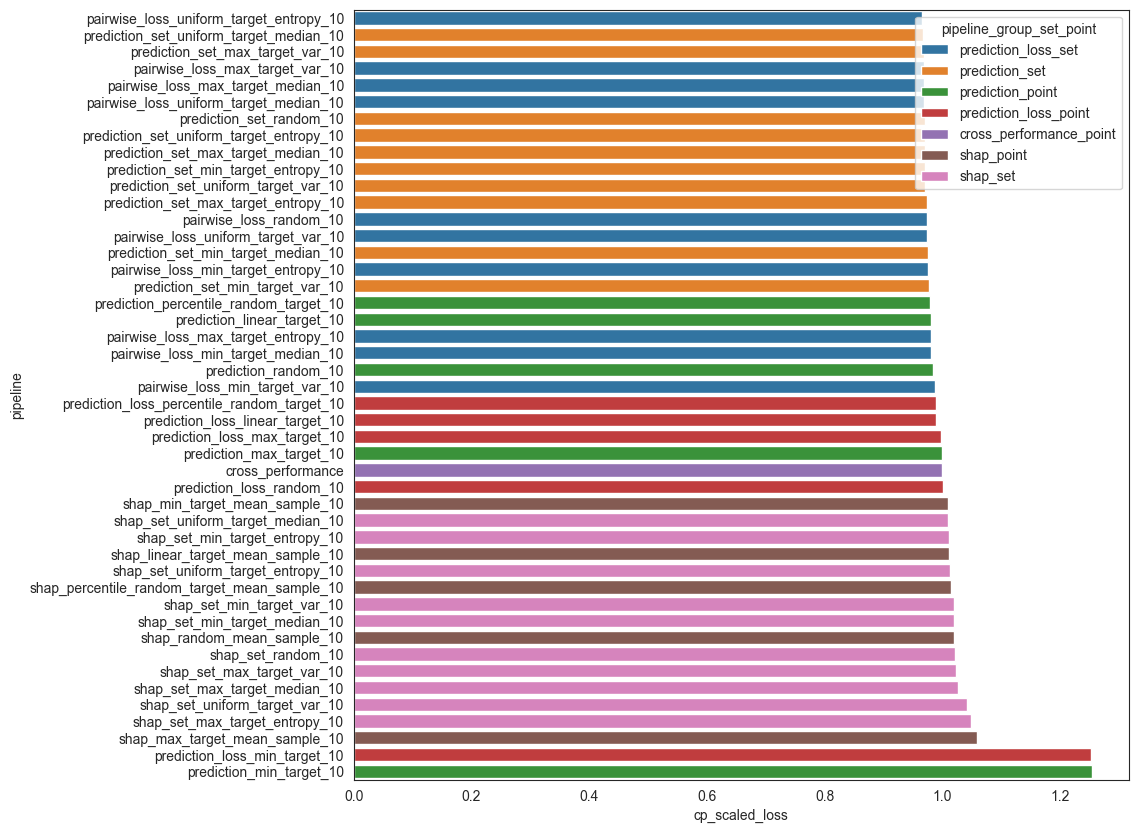

In [14]:
plt.figure(figsize=(10, 10))
sns.barplot(data=df_plot, x="cp_scaled_loss", y="pipeline", hue="pipeline_group_set_point")


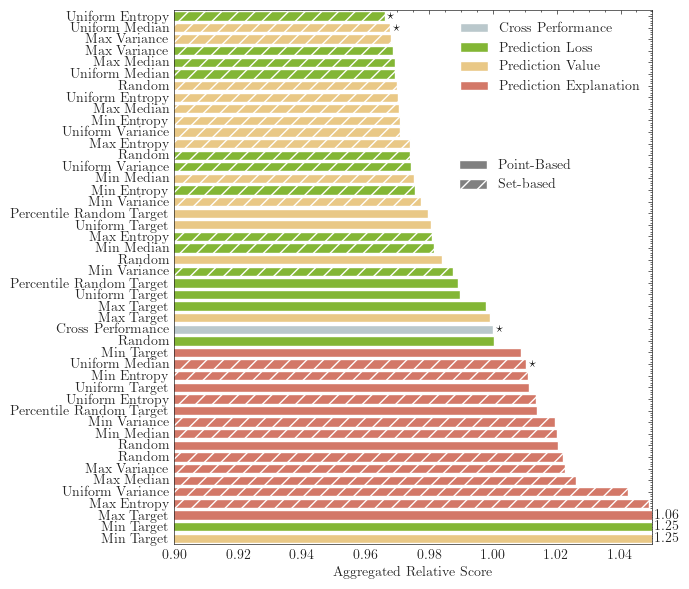

In [15]:
highlight_labels = [
    "pairwise_loss_uniform_target_entropy_10",
    "cross_performance",
    "prediction_set_uniform_target_median_10",
    "shap_set_uniform_target_median_10",
]

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def sanitize_pipeline_name(pipeline):
    splits = pipeline.split("_")
    if pipeline != "cross_performance":
        splits = splits[:-1]
    if pipeline.startswith("composing"):
        return "Ensemble"
    splits = [s for s in splits if s not in ["pairwise", "loss", "prediction", "mean", "sample", "shap", "set"]]
    splits = [s.capitalize().replace("Shap", "Prediction Explanation").replace("Pairwise", "Prediction") for s in splits]
    return " ".join(splits).replace("Linear", "Uniform").replace("Target ", "").replace("Var", "Variance")

def sanitize_pipeline_familiy_name(pipeline):
    if "pairwise" in pipeline:
        return "Prediction Loss"
    if "prediction_loss" in pipeline:
        return "Prediction Loss"
    if "shap" in pipeline:
        return "Prediction Explanation"
    if "shap_set" in pipeline:
        return "Prediction Explanation"
    if "prediction" in pipeline:
        return "Prediction Value"
    if "prediction_set" in pipeline:
        return "Prediction Value"
    if "cross_performance" in pipeline:
        return "Cross Performance"
    raise ValueError("Invalid pipeline family name" + pipeline)



with plt.style.context('science'):
    fig = plt.figure(figsize=(7, 6))
    sns.barplot(data=df_plot, x="cp_scaled_loss", y="pipeline", hue="pipeline_group", hue_order=pipeline_groups_clean, palette=colors)
    plt.xlabel("Aggregated Relative Score")
    plt.ylabel("")
    plt.xlim((0.9, 1.05))
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))  # 2 decimal places
    labels = [sanitize_pipeline_name(str(pipeline.get_text())) for pipeline in plt.gca().get_yticklabels()]
    plt.yticks(plt.gca().get_yticks(), labels)
    x_lim_min, x_lim_max = plt.gca().get_xlim()

    # Calculate consistent text offset
    ax = plt.gca()
    x_range = x_lim_max - x_lim_min
    bbox = ax.get_window_extent()
    width_points = bbox.width
    data_points_ratio = x_range / width_points
    text_offset = data_points_ratio * 3  # 3 points in point units

    # Ignore the patches in the legend
    sorted_patches = [p for p in sorted(ax.patches, key=lambda patch: patch.xy[1]) if p.get_height() > 0]

    # Store processed y-positions to avoid duplicates
    processed_positions = set()

    # First, handle highlighted pipelines
    for i, pipeline in enumerate(df_plot["pipeline"].unique()):
        if pipeline in highlight_labels:
            # Find bars for this pipeline
            bar_height = 0.8 / len(df_plot["pipeline_group"].unique())
            y_pos = i

            for patch in ax.patches:
                patch_center_y = patch.get_y() + patch.get_height() / 2
                # Check if patch is at the correct y-position
                if abs(patch_center_y - y_pos) < bar_height:
                    # Create a unique key for this position
                    pos_key = f"{patch_center_y:.3f}"
                    if pos_key in processed_positions:
                        continue
                    processed_positions.add(pos_key)

                    bar_end = patch.get_x() + patch.get_width()

                    # If bar extends beyond plot, add to the value text
                    if bar_end > x_lim_max:
                        # Find and remove existing text annotation at this position
                        for txt in ax.texts:
                            if abs(txt.get_position()[1] - patch_center_y) < 0.1:
                                txt.remove()

                        # Add text with box symbol
                        ax.text(x_lim_max + text_offset, patch_center_y,
                                f'{bar_end:.2f} \\star$', ha='left', va='center')
                    else:
                        # Add box at end of bar with consistent spacing
                        ax.text(bar_end + text_offset, patch_center_y, "$\\star$", ha='left', va='center')

                    # Only process one bar per y-position
                    break

    # Now handle remaining bars that extend beyond plot limits
    for patch in ax.patches:
        patch_center_y = patch.get_y() + patch.get_height() / 2
        pos_key = f"{patch_center_y:.3f}"

        if pos_key in processed_positions:
            continue

        bar_end = patch.get_x() + patch.get_width()
        if bar_end > x_lim_max:
            ax.text(x_lim_max + text_offset, patch_center_y,
                    f'{bar_end:.2f}', ha='left', va='center')
            processed_positions.add(pos_key)

    for patch, pipeline in zip(sorted_patches, df_plot['pipeline'].unique()):
        if is_set_pipeline(pipeline):
            patch.set_hatch("//")

    # Create shared legend at the bottom
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [sanitize_pipeline_familiy_name(label) for label in labels]
    plt.legend(handles, labels, frameon=False)
    # Add the second legend for line styles
    from matplotlib.patches import Patch
    line_handles = [
        Patch(facecolor="grey", edgecolor='white', # Use facecolor for fill, edgecolor for border
              label="Point-Based"),
        Patch(facecolor="grey", edgecolor='white', hatch="//",
              label="Set-based"),
    ]
    fig.legend(handles=line_handles, loc="lower center", bbox_to_anchor=(0.7425, 0.65), ncol=1, frameon=False)


    plt.tight_layout()
    plt.savefig("../../reports/figures/method_ranking/agg_performance.png", bbox_inches='tight')




In [16]:
df_plot.groupby("point_set").count()

,pipeline,cp_scaled_loss,pipeline_group,pipeline_group_set_point
point_set,,,,
point,16,16,16,16
set,30,30,30,30


In [17]:
df_grp = df[["dataset", "pipeline", "cluster_loss"]].groupby(["dataset", "pipeline"]).mean().reset_index()
df_grp[df_grp['pipeline'] == "cross_performance"]

,dataset,pipeline,cluster_loss
1,anomaly,cross_performance,0.535507
48,heating,cross_performance,3.250578
95,house_price,cross_performance,0.204130
142,weather_probabilistic,cross_performance,0.823048



# Overall Performance

In [18]:
best_performing_per_family = [
    "prediction_set_uniform_target_median_10",
    "pairwise_loss_uniform_target_entropy_10",
    "shap_set_uniform_target_median_10",
    "cross_performance"
]

In [19]:
df

,num_clusters,dataset,loss,pipeline,pipeline_group,cluster_loss,model_loss,cluster_var,model_var,cp_cluster_loss,cp_cluster_var,share_retained,cp_scaled_loss
4,57,anomaly,roc_auc,prediction_min_target_10,prediction,0.537933,0.605849,0.005604,0.029264,0.541689,0.005145,0.159664,1.006983
6,32,anomaly,roc_auc,prediction_min_target_10,prediction,0.519833,0.605849,0.002839,0.029264,0.527023,0.003488,0.089636,1.013830
7,35,anomaly,roc_auc,prediction_min_target_10,prediction,0.533797,0.605849,0.002905,0.029264,0.532456,0.003378,0.098039,0.997487
8,67,anomaly,roc_auc,prediction_min_target_10,prediction,0.540063,0.605849,0.005771,0.029264,0.549139,0.006092,0.187675,1.016805
9,60,anomaly,roc_auc,prediction_min_target_10,prediction,0.540689,0.605849,0.005450,0.029264,0.543551,0.005353,0.168067,1.005293
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10149,14,weather_probabilistic,crps,shap_min_target_mean_sample_10,shap,0.845051,0.854452,0.002179,0.014164,0.824645,0.004683,0.028169,1.024746
10150,22,weather_probabilistic,crps,shap_min_target_mean_sample_10,shap,0.849792,0.854452,0.004148,0.014164,0.814272,0.005970,0.044266,1.043622
10151,22,weather_probabilistic,crps,shap_min_target_mean_sample_10,shap,0.849792,0.854452,0.004148,0.014164,0.814272,0.005970,0.044266,1.043622
10152,22,weather_probabilistic,NaN,shap_min_target_mean_sample_10,shap,0.849792,0.854452,0.004148,0.014164,0.814272,0.005970,0.044266,1.043622


In [20]:
df[(df["dataset"] == 'heating') & (df["pipeline"].str.contains("cross_performance"))]

,num_clusters,dataset,loss,pipeline,pipeline_group,cluster_loss,model_loss,cluster_var,model_var,cp_cluster_loss,cp_cluster_var,share_retained,cp_scaled_loss
3640,192,heating,mae,cross_performance,cross_performance,2.992750,2.573569,7.932918,9.596847,2.992750,7.932918,0.209378,1.0
3644,229,heating,mae,cross_performance,cross_performance,2.812119,2.573569,8.522981,9.596847,2.812119,8.522981,0.249727,1.0
3645,220,heating,mae,cross_performance,cross_performance,2.823327,2.573569,8.499756,9.596847,2.823327,8.499756,0.239913,1.0
3647,210,heating,mae,cross_performance,cross_performance,2.974902,2.573569,7.960659,9.596847,2.974902,7.960659,0.229008,1.0
3653,174,heating,mae,cross_performance,cross_performance,2.993217,2.573569,7.821652,9.596847,2.993217,7.821652,0.189749,1.0
3654,18,heating,mae,cross_performance,cross_performance,4.110712,2.573569,8.016063,9.596847,4.110712,8.016063,0.019629,1.0
3655,27,heating,mae,cross_performance,cross_performance,3.611653,2.573569,8.825934,9.596847,3.611653,8.825934,0.029444,1.0
3656,9,heating,mae,cross_performance,cross_performance,5.108623,2.573569,13.861587,9.596847,5.108623,13.861587,0.009815,1.0
3658,45,heating,mae,cross_performance,cross_performance,3.453347,2.573569,8.237947,9.596847,3.453347,8.237947,0.049073,1.0
3659,73,heating,mae,cross_performance,cross_performance,3.278360,2.573569,7.799219,9.596847,3.278360,7.799219,0.079607,1.0


In [21]:
experiment_date_consolidation = "2025-04-08-08:07"
experiment_consolidation = "consolidation_strategy"
df_consolidation, _, _ = read_experiment_results_consolidation(experiment_consolidation, experiment_date_consolidation)
print(df_consolidation['dataset'].unique())
df_consolidation = df_consolidation[(df_consolidation['dataset'].str.contains("representative")) & (df_consolidation['pipeline'] == "pairwise_loss_uniform_target_entropy_10")]
df_consolidation


['anomaly_representative' 'heating_representative'
 'house_price_representative' 'weather_probabilistic_representative'
 'anomaly_retraining' 'heating_retraining' 'house_price_retraining'
 'weather_probabilistic_retraining']


,dataset,loss,pipeline,pipeline_group,cluster_loss,model_loss,cluster_var,model_var,num_clusters
0,anomaly_representative,roc_auc,pairwise_loss_uniform_target_entropy_10,pairwise_loss,0.572388,0.605849,0.009877,0.029264,135
1,anomaly_representative,roc_auc,pairwise_loss_uniform_target_entropy_10,pairwise_loss,0.565423,0.605849,0.010311,0.029264,132
2,anomaly_representative,roc_auc,pairwise_loss_uniform_target_entropy_10,pairwise_loss,0.554744,0.605849,0.007190,0.029264,92
3,anomaly_representative,roc_auc,pairwise_loss_uniform_target_entropy_10,pairwise_loss,0.559793,0.605849,0.008531,0.029264,103
4,anomaly_representative,roc_auc,pairwise_loss_uniform_target_entropy_10,pairwise_loss,0.542599,0.605849,0.005623,0.029264,57
...,...,...,...,...,...,...,...,...,...
195,weather_probabilistic_representative,crps,pairwise_loss_uniform_target_entropy_10,pairwise_loss,0.905758,0.854452,0.006783,0.014164,47
196,weather_probabilistic_representative,crps,pairwise_loss_uniform_target_entropy_10,pairwise_loss,1.010576,0.854452,0.006208,0.014164,2
197,weather_probabilistic_representative,crps,pairwise_loss_uniform_target_entropy_10,pairwise_loss,0.924972,0.854452,0.004952,0.014164,14
198,weather_probabilistic_representative,crps,pairwise_loss_uniform_target_entropy_10,pairwise_loss,0.917749,0.854452,0.005566,0.014164,22


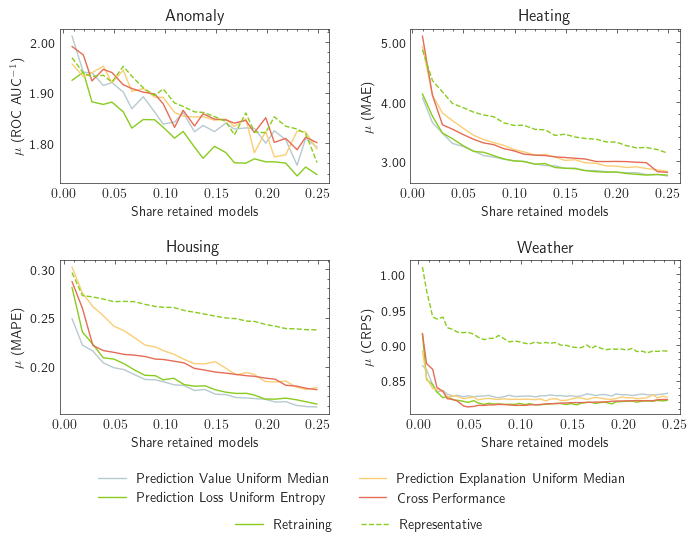

In [22]:
sns.set_style("white")

dataset_labels = ["Anomaly", "Heating", "Housing", "Weather"]

def sanitize_pipeline_name_overall(pipeline):
    splits = pipeline.split("_")
    if pipeline != "cross_performance":
        splits = splits[:-1]
    if pipeline.startswith("composing"):
        return "Ensemble"
    splits = [s.capitalize().replace("Prediction", "Prediction Value").replace("Shap", "Prediction Explanation").replace("Loss", "").replace("Pairwise", "Prediction Loss Set") for s in splits]
    s = " ".join(splits).replace("Linear", "Uniform").replace("Mean Sample", "")
    if s == "Cross Performance":
        return s
    return s.replace("Set", "").replace("Var", "Variance").replace("Target ", "")# + " (Set)"

with plt.style.context('science'):
    fig, axes = plt.subplots(2, 2, figsize=(8, 5))
    axes = axes.flatten()
    for i, (dataset, dataset_size, loss_maximize, loss) in enumerate(
            zip(datasets, dataset_sizes, losses_maximize, losses)):
        df_dataset = df[df["dataset"] == dataset].copy()
        df_dataset["share_retained"] = df_dataset["num_clusters"].apply(lambda x: int(x) / dataset_size)
        df_dataset = df_dataset[df_dataset["share_retained"] <= 0.25]
        df_dataset = df_dataset.sort_values(by="share_retained")
        if loss_maximize:
            df_dataset["cluster_loss"] = 1 / df_dataset["cluster_loss"]

        ax = axes[i]
        plot_df = df_dataset[df_dataset["pipeline"].isin(best_performing_per_family)]
        sns.lineplot(data=plot_df, x="share_retained", y="cluster_loss", hue="pipeline",
                     hue_order=best_performing_per_family, ax=ax, palette=colors)

        df_consolidation_dataset = df_consolidation[df_consolidation["dataset"] == dataset + "_representative"].copy()
        df_consolidation_dataset["share_retained"] = df_consolidation_dataset["num_clusters"].apply(lambda x: int(x) / dataset_size)
        df_consolidation_dataset = df_consolidation_dataset[df_consolidation_dataset["share_retained"] <= 0.25]
        df_consolidation_dataset = df_consolidation_dataset.sort_values(by="share_retained")
        if loss_maximize:
            df_consolidation_dataset["cluster_loss"] = 1 / df_consolidation_dataset["cluster_loss"]
        ax.plot(df_consolidation_dataset["share_retained"], df_consolidation_dataset["cluster_loss"], c="#88cc1f", linestyle="dashed")

        ax.set_xlabel("Share retained models")
        if loss_maximize:
            ax.set_ylabel("$\mu$ (ROC AUC$^{-1}$)")
        else:
            ax.set_ylabel(f"$\mu$ ({loss.upper().replace('_', ' ')})")
        new_labels = {pipeline: sanitize_pipeline_name_overall(pipeline) for pipeline in best_performing_per_family}
        ax.legend().remove()
        ax.set_title(dataset_labels[i])
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

    # Add the first legend for pipelines
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, [new_labels[label] for label in labels], bbox_to_anchor=(0.85, -0.3), ncol=2, frameon=False)

    # Add the second legend for line styles
    from matplotlib.lines import Line2D
    line_handles = [
        Line2D([0], [0], color="#88cc1f", linestyle="solid", label="Retraining"),
        Line2D([0], [0], color="#88cc1f", linestyle="dashed", label="Representative"),
    ]
    fig.legend(handles=line_handles, loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.savefig("../../reports/figures/method_ranking/overall_scaled.png", bbox_inches='tight')


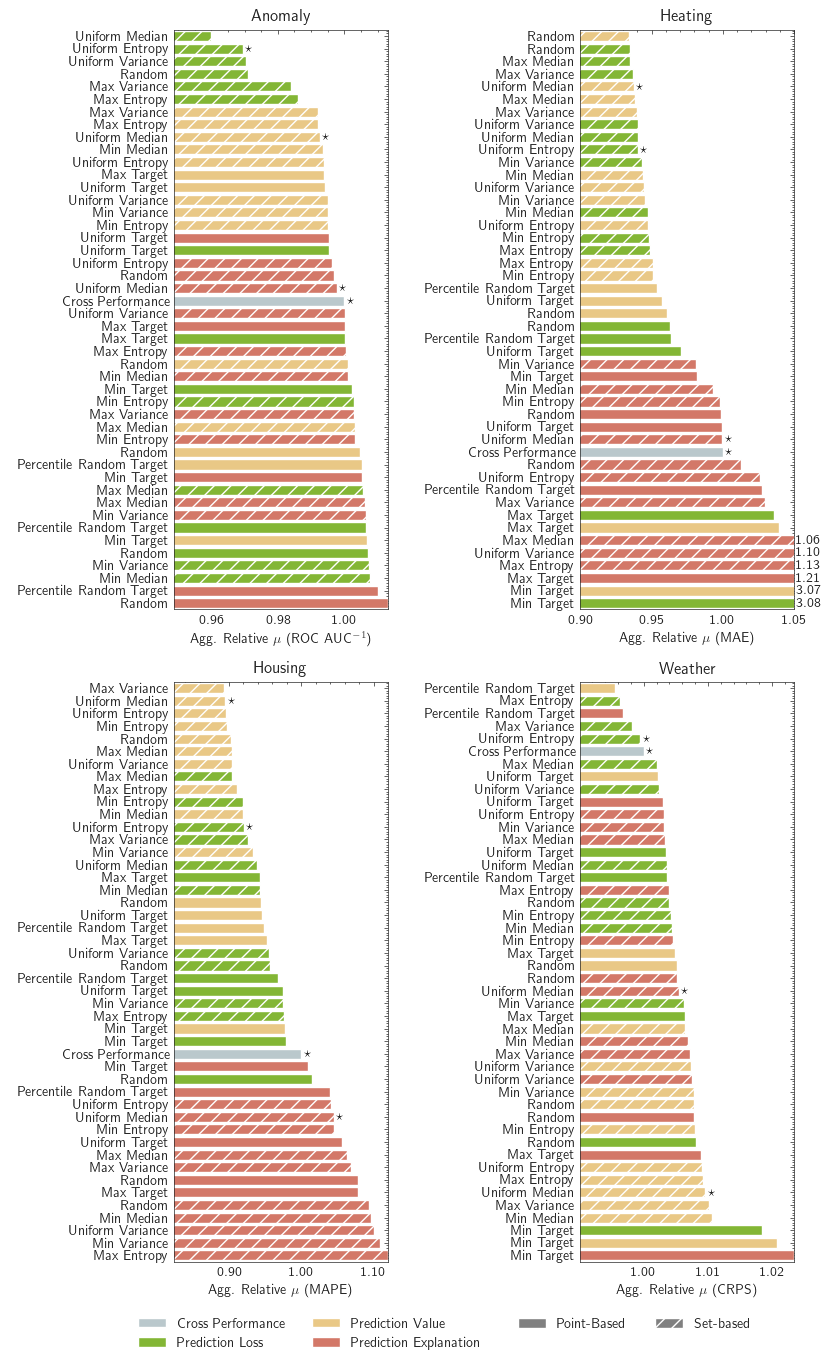

In [23]:

def sanitize_pipeline_name(pipeline):
    splits = pipeline.split("_")
    if pipeline != "cross_performance":
        splits = splits[:-1]
    if pipeline.startswith("composing"):
        return "Ensemble"
    splits = [s for s in splits if s not in ["pairwise", "loss", "prediction", "mean", "sample", "shap"]]
    splits = [s.capitalize().replace("Shap", "Shapley").replace("Set", "").replace("Pairwise", "Prediction") for s in splits]
    s = " ".join(splits).replace("Linear", "Uniform")
    # Remove dag symbol from here
    return s.replace("Var", "Variance").replace("Target ", "")

highlight_labels = [
    "pairwise_loss_uniform_target_entropy_10",
    "cross_performance",
    "prediction_set_uniform_target_median_10",
    "shap_set_uniform_target_median_10",
]

with plt.style.context('science'):
    fig, axes = plt.subplots(2, 2, figsize=(8, 16))
    axes = axes.flatten()

    # Define a consistent offset for the dag symbol
    dag_offset = 0.001  # Consistent small offset for all subplots

    for i, (dataset, dataset_size, loss_maximize, loss) in enumerate(
            zip(datasets, dataset_sizes, losses_maximize, losses)):
        df_dataset = df[(df["dataset"] == dataset) & (~df["pipeline_group"].isin(["composing", "random_clustering"]))].copy()
        ax = axes[i]
        average_score = {k: gmean(df_dataset[df_dataset["pipeline"] == k]["cp_scaled_loss"]) for k in
                         df_dataset["pipeline"].unique()}
        average_score_df = pd.DataFrame(average_score.items(), columns=["pipeline", "cp_scaled_loss"])
        average_score_df = average_score_df.sort_values(by="cp_scaled_loss")
        average_score_df = average_score_df.merge(df_dataset[["pipeline", "pipeline_group"]].drop_duplicates(),
                                                  on="pipeline")

        # Create the barplot as usual
        sns.barplot(data=average_score_df, x="cp_scaled_loss", y="pipeline", hue="pipeline_group",
                    hue_order=pipeline_groups_clean, ax=ax, palette=colors)

        if dataset == "heating":
            ax.set_xlim(0.9, 1.05)
        else:
            ax.set_xlim(average_score_df["cp_scaled_loss"].min() - average_score_df["cp_scaled_loss"].std(),
                        average_score_df["cp_scaled_loss"].max())
        x_lim_min, x_lim_max = ax.get_xlim()

        # Calculate x-axis point units per point for consistent visual spacing
        x_range = x_lim_max - x_lim_min
        bbox = ax.get_window_extent()
        width_points = bbox.width
        data_points_ratio = x_range / width_points
        text_offset = data_points_ratio * 3  # 3 points in point units

        # Ignore the patches in the legend
        sorted_patches = [p for p in sorted(ax.patches, key=lambda patch: patch.xy[1]) if p.get_height() > 0]


        # Store processed y-positions to avoid duplicates
        processed_positions = set()

        # After creating the plot, add the dag symbols
        for j, pipeline in enumerate(average_score_df["pipeline"]):
            if pipeline in highlight_labels:
                # Find the corresponding bar(s) for this pipeline
                bar_height = 0.8 / len(average_score_df["pipeline_group"].unique())  # Estimate bar height
                y_pos = j

                # Loop through all patches to find any that correspond to this y-position
                for patch in ax.patches:
                    patch_center_y = patch.get_y() + patch.get_height() / 2
                    # Check if patch is at the correct y-position (with some tolerance)
                    if abs(patch_center_y - y_pos) < bar_height:
                        # Create a unique key for this position to avoid duplicates
                        pos_key = f"{i}_{patch_center_y:.3f}"
                        if pos_key in processed_positions:
                            continue
                        processed_positions.add(pos_key)

                        bar_end = patch.get_x() + patch.get_width()

                        # If bar extends beyond plot, add to the value text
                        if bar_end > x_lim_max:
                            # Find existing text annotation at this position if any
                            for txt in ax.texts:
                                if abs(txt.get_position()[1] - patch_center_y) < 0.1:
                                    # Remove it to replace with our version including dag
                                    txt.remove()

                            # Add new text with dag symbol
                            ax.text(x_lim_max + text_offset, patch_center_y,
                                    f'{bar_end:.2f} $\\star$', ha='left', va='center')
                        else:
                            # Add dag at end of bar with consistent spacing
                            ax.text(bar_end + text_offset, patch_center_y,
                                    "$\\star$", ha='left', va='center')

                        # Only process one bar per y-position
                        break

        # For bars that extend beyond the plot limit (without dag)
        for patch in ax.patches:
            patch_center_y = patch.get_y() + patch.get_height() / 2
            pos_key = f"{i}_{patch_center_y:.3f}"

            if pos_key in processed_positions:
                continue

            bar_end = patch.get_x() + patch.get_width()
            if bar_end > x_lim_max:
                ax.text(x_lim_max + text_offset, patch_center_y,
                        f'{bar_end:.2f}', ha='left', va='center')
                processed_positions.add(pos_key)

        for patch, pipeline in zip(sorted_patches, average_score_df['pipeline'].unique()):
            if is_set_pipeline(pipeline):
                patch.set_hatch("//")

        if loss == "roc_auc":
            ax.set_xlabel(r"Agg. Relative $\mu$ (ROC AUC$^{-1}$)")
        else:
            ax.set_xlabel(f"Agg. Relative $\mu$ ({loss.upper()})")
        ax.set_ylabel("")
        ax.set_yticks(ax.get_yticks())
        yticklabels = [sanitize_pipeline_name(str(pipeline.get_text())) for pipeline in ax.get_yticklabels()]
        ax.set_yticklabels(yticklabels)
        ax.set_title(dataset_labels[i])
        ax.legend().remove()
        ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [sanitize_pipeline_familiy_name(label) for label in labels]
    plt.legend(handles, labels, bbox_to_anchor=(-0.4, -0.075), ncol=2, frameon=False)

    from matplotlib.patches import Patch
    line_handles = [
        Patch(facecolor="grey", edgecolor='white', # Use facecolor for fill, edgecolor for border
              label="Point-Based"),
        Patch(facecolor="grey", edgecolor='white', hatch="//",
              label="Set-based"),
    ]
    fig.legend(handles=line_handles, loc="lower center", bbox_to_anchor=(0.7, 0.059), ncol=2, frameon=False)

    plt.subplots_adjust(wspace=.9, hspace=0.125)
    plt.savefig("../../reports/figures/method_ranking/dataset_agg_performance.png", bbox_inches='tight')